In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from azula.guidance import MMPSDenoiser
from azula.sample import DDPMSampler, EulerSampler
from einops import rearrange
from functools import partial
from lpdm.data import field_preprocess, get_well_dataset
from lpdm.diffusion import get_denoiser
from lpdm.nn.autoencoder import AutoEncoder
from omegaconf import OmegaConf
from pathlib import Path

_ = torch.manual_seed(0)

In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/euler_open_dit_medium_adamw_0.0001_0.0_linear_None_0.99_hn97mbbo")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
aepath = Path(runpath / "autoencoder")
device = "cuda"

## Data

In [3]:
testset = get_well_dataset(
    path=f"/mnt/ceph/users/polymathic/the_well/datasets/{cfg.dataset.physics}",
    split="test",
    steps=cfg.trajectory.length,
    dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
autoencoder = AutoEncoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

autoencoder.load_state_dict(torch.load(aepath / "state.pth"))
autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 64, eps=1e-05, affine=False)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1-2): 2 x ResBlock(
          (block): Sequential(
            (0): GroupNorm(16, 128, eps=1e-05, affine=False)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )

## Denoiser

In [5]:
denoiser = get_denoiser(
    shape=(cfg.ae.lat_channels, cfg.trajectory.length, 64, 64),
    label_features=testset.metadata.n_constant_scalars,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state.pth"))
denoiser.cuda()
denoiser.eval()

ImprovedPreconditionedDenoiser(
  (backbone): FlattenWrapper(
    (wrappee): EmbeddingWrapper(
      (backbone): DiT(
        (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=2, w=2)
        (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=2, w=2)
        (in_proj): Linear(in_features=16, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=32, bias=True)
        (positional_embedding): Sequential(
          (0): Linear(in_features=3, out_features=1024, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (blocks): ModuleList(
          (0-15): 16 x DiTBlock(
            (norm): LayerNorm(dim=-1)
            (ada_zero): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=True)
              (1): SiLU()
              (2): Linear(in_features=256, out_features=6144, bias=True)
              (3): Rearrange('

In [6]:
sum(p.numel() for p in denoiser.parameters())

128228128

## Evaluation

In [7]:
sampler = EulerSampler(denoiser, steps=256).to(device)

label = torch.tensor([1.13]).to(device)

z1 = sampler.init((1, 4 * cfg.trajectory.length * 64 * 64))
z0 = sampler(z1, label=label)
z0 = z0.reshape((1, 4, cfg.trajectory.length, 64, 64))

with torch.no_grad():
    x = torch.vmap(autoencoder.decode, in_dims=2, out_dims=2)(z0)

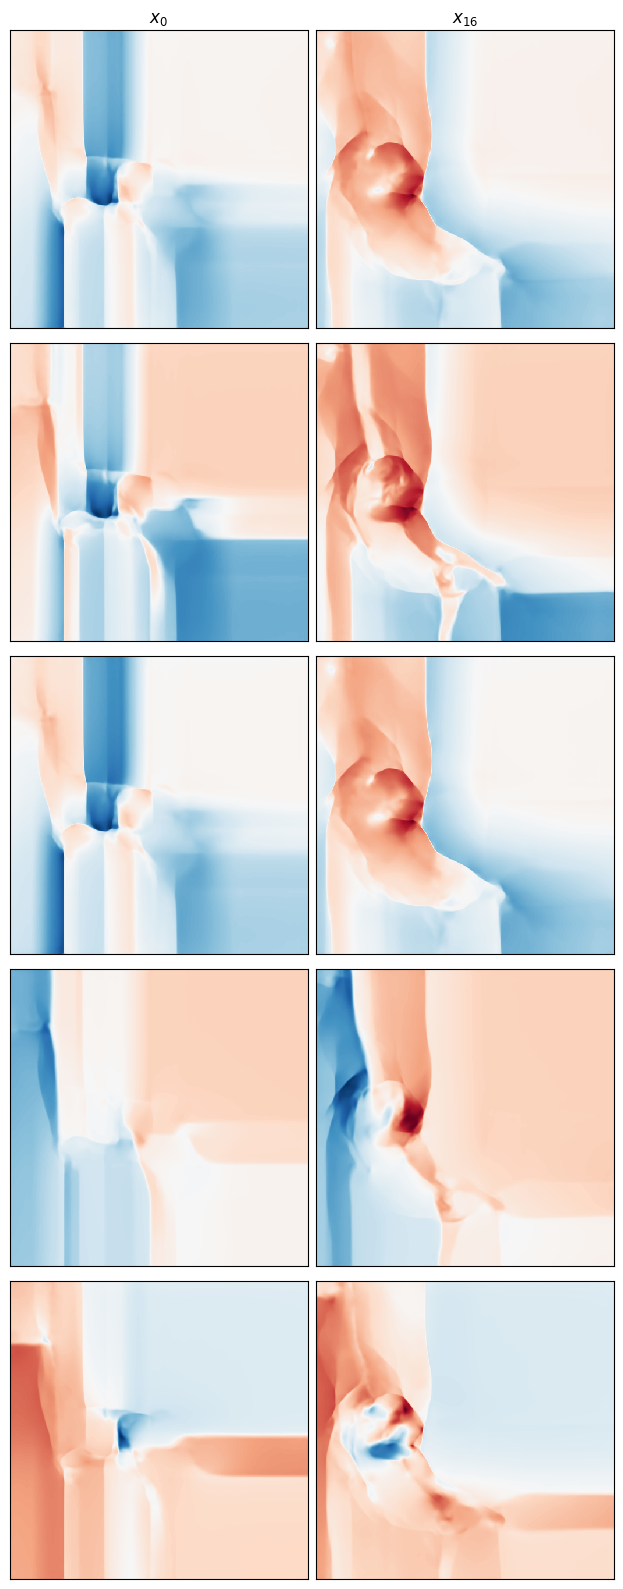

In [8]:
x = x.squeeze(0).cpu()

fig, axs = plt.subplots(5, cfg.trajectory.length, figsize=(3.2 * cfg.trajectory.length, 16))

for i in range(cfg.trajectory.length):
    axs[0, i].set_title(rf"$x_{{{i * cfg.trajectory.stride}}}$")

for field in range(5):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    for i in range(cfg.trajectory.length):
        axs[field, i].imshow(
            x[field, i], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, i].set_xticks([])
        axs[field, i].set_yticks([])

plt.tight_layout()

## Condition

In [9]:
batch = testset[13]
x = batch["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> 1 C L H W")

label = batch["constant_scalars"].to(device)

with torch.no_grad():
    z = torch.vmap(autoencoder.encode, in_dims=2, out_dims=2)(x)

In [10]:
cond_denoiser = MMPSDenoiser(
    denoiser,
    A=lambda z: z.reshape((4, -1, 64, 64))[..., :, 0, :, :].reshape(1, -1),
    y=z[..., :, 0, :, :].reshape(1, -1),
    var_y=1e-6,
    iterations=1,
)

cond_sampler = DDPMSampler(cond_denoiser, steps=256).to(device)

z1 = cond_sampler.init((1, 4 * cfg.trajectory.length * 64 * 64))
z0 = cond_sampler(z1, label=label)
z0 = z0.reshape((1, 4, cfg.trajectory.length, 64, 64))

with torch.no_grad():
    x_hat = torch.vmap(autoencoder.decode, in_dims=2, out_dims=2)(z0)

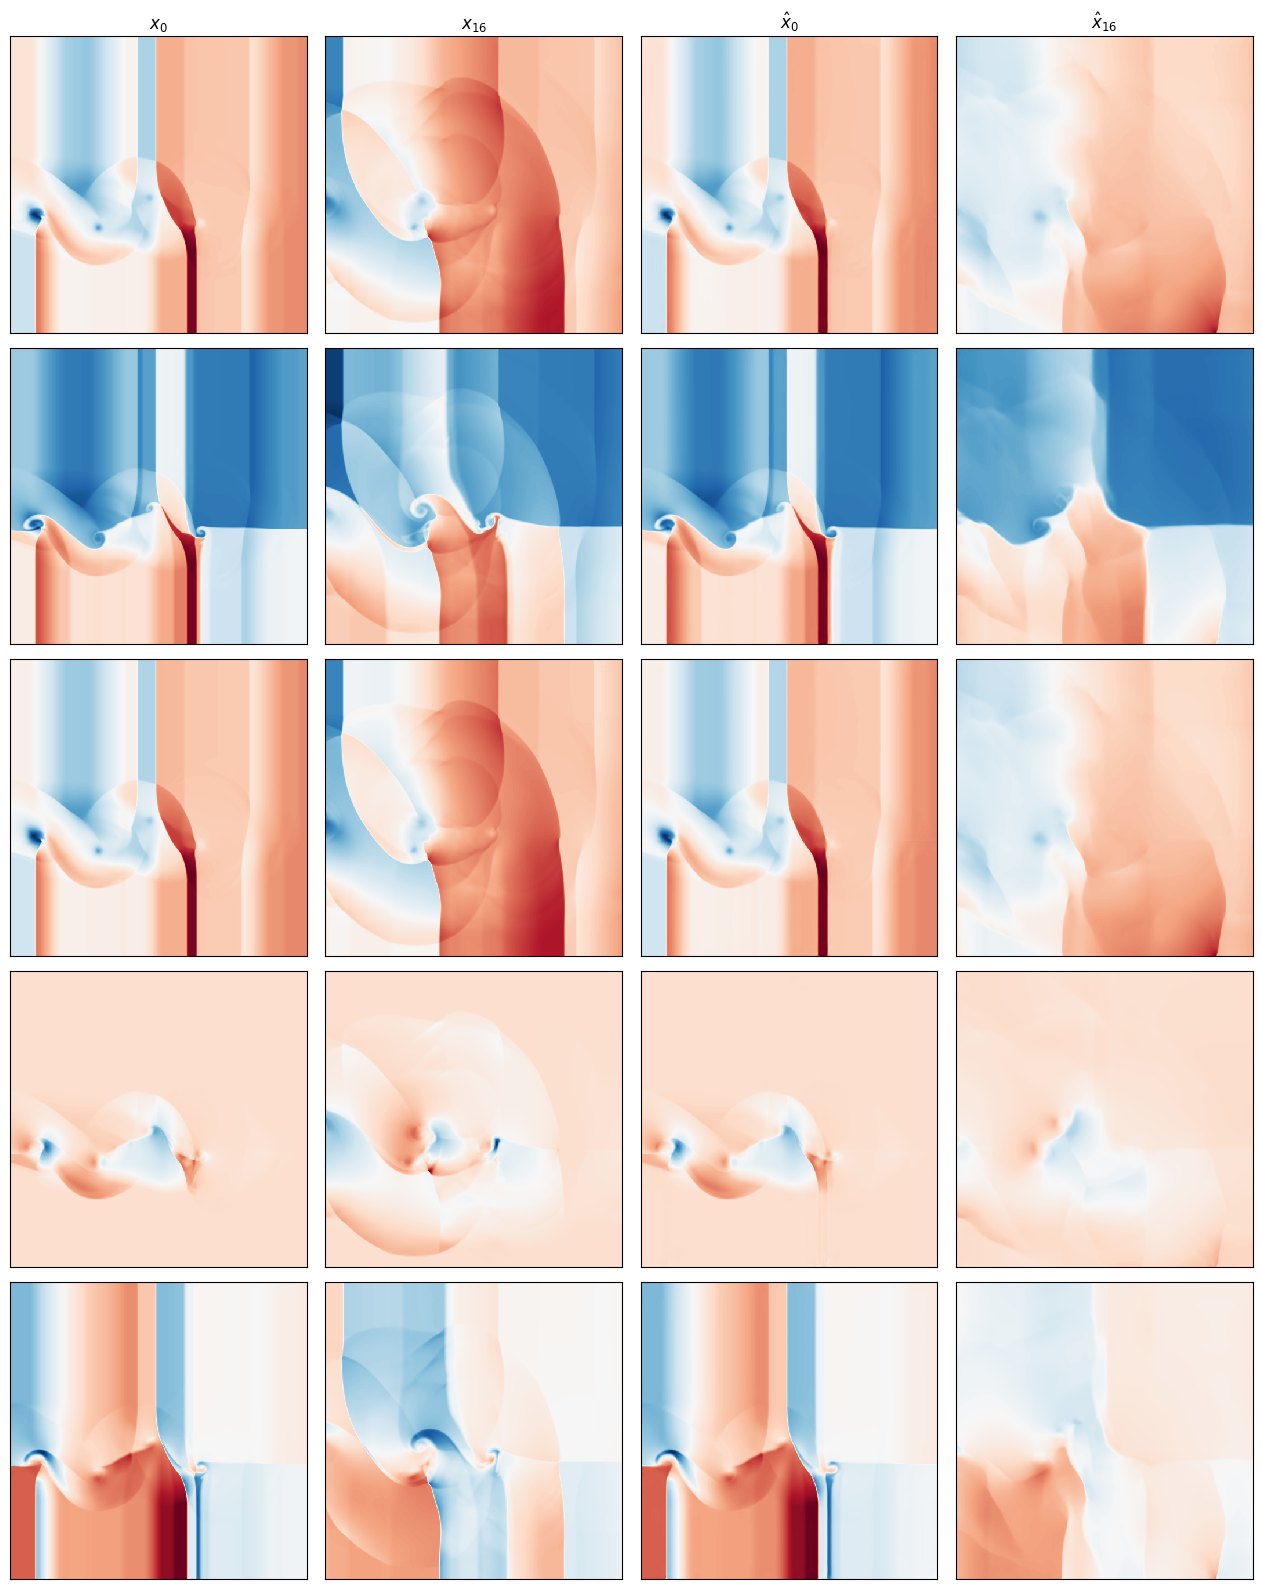

In [11]:
x = x.squeeze(0).cpu()
x_hat = x_hat.squeeze(0).cpu()

fig, axs = plt.subplots(5, 2 * cfg.trajectory.length, figsize=(6.4 * cfg.trajectory.length, 16))

for i in range(cfg.trajectory.length):
    axs[0, i].set_title(rf"$x_{{{i * cfg.trajectory.stride}}}$")
    axs[0, i + cfg.trajectory.length].set_title(rf"$\hat{{x}}_{{{i * cfg.trajectory.stride}}}$")

for field in range(5):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    for i in range(cfg.trajectory.length):
        axs[field, i].imshow(
            x[field, i], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, i].set_xticks([])
        axs[field, i].set_yticks([])

        axs[field, i + cfg.trajectory.length].imshow(
            x_hat[field, i], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, i + cfg.trajectory.length].set_xticks([])
        axs[field, i + cfg.trajectory.length].set_yticks([])

plt.tight_layout()